# Calculating summary statistics for catchments from gridded data
For this work we will be summarizing gridded data to watershed catchments. Quite often you have a situtation when you want to summarize raster datasets based on vector geometries, such as calculating the average elevation of a specific area.

Rasterstats is a Python module that does exactly that, easily. Before we get started however, we will need to load the rasterstats package from the Anaconda prompt (terminal), by opening the prompt and typing pip install rasterstats. We will also need to package descartes, so type pip install descartes as well before closing the prompt.

There are severeal steps needed to summarize a raster dataset using watershed catchments:

- Load raster and vector data
- Convert raster data to a format most applicable to research question
- Generate zonal statistics of the raster for the vector data
- Output and create meaningful information from the zonal statistics

For this work, we will follow an example of determining the percent impervious for approximately 150 HUC12 watersheds in in northeastern Wisconsic. Step one, as always, is to load the necessary python packages.

In [1]:
import rasterio, os, csv
from rasterio.plot import show
from rasterstats import zonal_stats
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent


It is also very helpful to specify a working folder. Examples of this could include 'C:temp' or for the purposes of this workshop 'C:\ACWA_workshop_files'. To create a working directory we can specify the file path and if the folder does not exist have Windows create it.

In [2]:
# Create a working directory
working_directory = 'C:\ACWA_workshop_files\Ex3_SummarizeDataByCatchments'
if not os.path.exists(working_directory): os.makedirs(working_directory)

### Read in the National Land Cover Database
The best source of US land cover data is from the Multi-Resolution Land Characteristics Consortium (MRLC). MRLC is a partnership of Federal agencies working together to produce current, nationally consistent, land cover products for all 50 states and Puerto Rico.

The most recent NCLD release is for 2016. It contains 28 different land cover products characterizing land cover and land cover change across 7 epochs from 2001-2016, urban imperviousness and urban imperviousness change across 4 epochs from 2001-2016, tree canopy and tree canopy change across 2 epochs from 2011-2016 and western U.S. shrub and grassland areas for 2016. Data are available on the MRLC website (https://www.mrlc.gov/), either as prepackaged products or custom product areas can be interactively chosen using the MRLC viewer.

For this work, we've already downloaded the 2016 National Land Cover product and clipped it to our area of interest. It can be found in the Day 2 data folder, titled "XXXX.tif".

For our watershed catchments, we will use HUC12s. A hydrologic unit (HUC12) is a drainage area delineated to nest in a multi-level, hierarchical drainage system. Its boundaries are defined by hydrographic and topographic criteria that delineate an area of land upstream from a specific point on a river, stream or similar surface waters.

The HUC12 data for this excercise has also been pre-downloaded and formatted. It can be found in the Day 2 data folder, titled "XXXX.shp". First, let's read in both types of data (raster and vector).

In [3]:
data_folder = 'E:/R course/Day 2/data'

# Read in the NLCD data
NLCD_fp = os.path.join(data_folder, 'WI_NLCD_2016.tif')
NLCD = rasterio.open(NLCD_fp)

# Read in the HUC12 catchments
HUC12_fp = os.path.join(data_folder, 'WI_HUC12s.shp')
HUC12 = gpd.read_file(HUC12_fp)

### Ensure both data types are in the same projection
One quick, but very helpful, step to remember is to ensure that both data types are in the same projection. To do this, we will coerce the HUC12 data into the same projection as the National Land Cover Data and then plot the data to makes sure our boundaries are lining up.

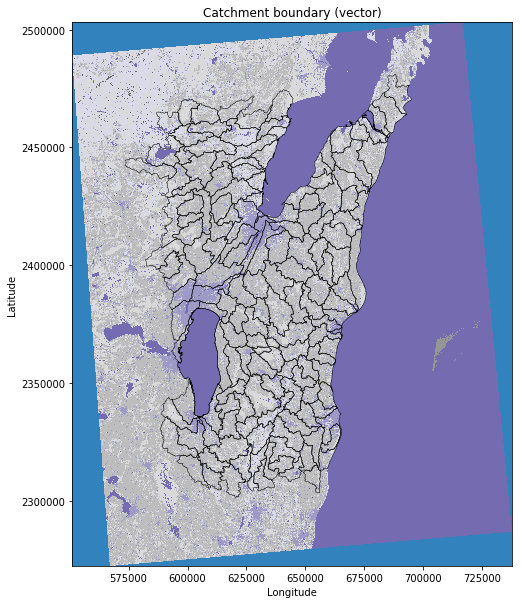

In [4]:
# Reproject everything to the same projection (CRS)
HUC12 = HUC12.to_crs(crs=NLCD.crs.data)

# Plot the land cover data and overlay the catchments for quick look
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Catchment boundary (vector)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
HUC12.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=0.5)

ax = show((NLCD,1), cmap='tab20c')

### Calculate zonal statistics using rasterstats
Perfect, now that we know our data lines up it is time to begin summarizing our raster by the catchment boundaries. In this example, we want to know what the percent impervious is within each HUC12. Start by converting the raster data into a numpy array and then storing a variable with the 'affine' information from the raster. Affine transformations enable for a seemless transition from numerical 2D data storage and the 3D formats of spatial data. 

In [5]:
# Read the raster values
array = NLCD.read(1)

# Get the affine
affine = NLCD.transform

There are a few different ways to ultimately determine the percet impervious of each watershed. One such method we will explore is to reclassify the raster into a binary impervious/non-impervious array and then summarize the results for each catchment. Using the land cover classification table below we can use the numpy.select function to reclassify each of the values. 

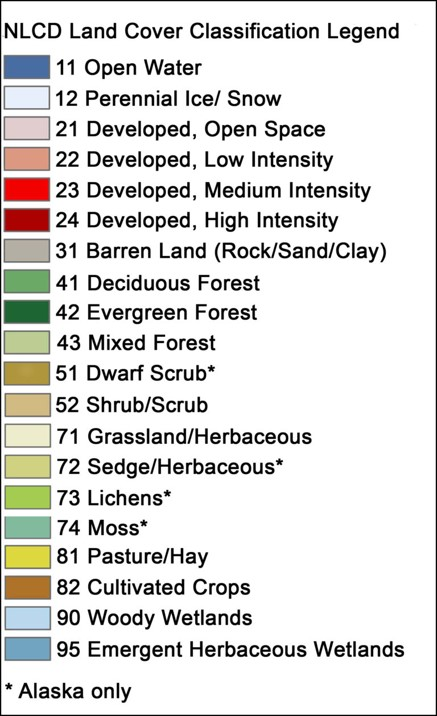

In [6]:
# Check to see what unique values are in the array
uni = np.unique(array)
print(uni)

# Create an impervious array
conditions = [array == 21, array == 22, array == 23, array == 24, (array > 24) & (array < 21)]
choices = [1, 1, 1, 1, 0]

impervious = np.select(conditions, choices)
imp_uni = np.unique(impervious)
imp_uni

[-128   11   21   22   23   24   31   41   42   43   52   71   81   82
   90   95]


array([0, 1])

Once we've created an array of the impervious classes, we can then run zonat statistics on that array. 

The typical usage of the zonalstats functions involves two arguments, a vector and a raster dataset. By default, the zonal_stats function will return the following statistics:
- min
- max
- mean
- count

Optionally, these statistics are also available.
- sum
- std
- median
- majority
- minority
- unique
- range
- nodata

You can specify the statistics to calculate using the stats argument in the code below.

In [7]:
# calculate zonal statistics for impervious
stats_imp = zonal_stats(HUC12, impervious, affine=affine,
                        stats=['min', 'max', 'mean', 'count', 'sum'],
                        all_touched=True, geojson_out=True)

C:\Users\brian.pickard\AppData\Local\Continuum\anaconda3\lib\site-packages\rasterstats\io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


### Reading, writing, and manipulatingInterpreting and creating  using rasterstats
Converting the output of the zonal stats function may look a bit clunky, but once you get used to the format it's quite easy to export the data to a raw csv. Once it's written to a csv we can import the data as a dataframe and manipulate the data. 

In [8]:
# Get the attribute names of each column from zonal stats:
keys_imp = stats_imp[0]['properties'].keys()

# Specify file location to save csv
save_location = os.path.join(working_directory, 'HUC12_impervious_zonal_statistics.csv')

# Write the attribute headers and data to csv
with open(save_location, 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, keys_imp)
    dict_writer.writeheader()
    for row in stats_imp:
        dict_writer.writerow(row['properties'])

# Read in clean data as csv
csv = pd.read_csv(save_location)

# Generate a percent impervious
csv['pct_imp'] = csv['sum']/csv['count']
csv = csv.sort_values(['pct_imp'], ascending=[False])
csv

,huc,huc12,name,objectid,min,max,mean,count,sum,pct_imp
114,4.030204e+10,40302040205,Garners Creek-Fox River,51411,0.0,1.0,0.695438,114962,79949.0,0.695438
111,4.030204e+10,40302040202,Mud Creek,51405,0.0,1.0,0.668059,74468,49749.0,0.668059
10,4.030204e+10,40302040405,City of Green Bay-Fox River,38868,0.0,1.0,0.608847,87237,53114.0,0.608847
124,4.030203e+10,40302030101,City of Oshkosh-Frontal Lake Winnebago,51560,0.0,1.0,0.603930,44068,26614.0,0.603930
110,4.030204e+10,40302040201,Little Lake Butte des Mortes,51403,0.0,1.0,0.558292,126665,70716.0,0.558292
...,...,...,...,...,...,...,...,...,...,...
82,4.030103e+10,40301030102,North Branch Pensaukee River,50036,0.0,1.0,0.037379,119478,4466.0,0.037379
142,4.030202e+10,40302020807,Mink Creek-Shioc River,51879,0.0,1.0,0.036081,136915,4940.0,0.036081
53,4.030101e+10,40301010408,South Branch Manitowoc River,49435,0.0,1.0,0.030871,38127,1177.0,0.030871
20,4.030102e+10,40301020111,Sturgeon Bay,40153,0.0,1.0,0.029713,23592,701.0,0.029713


### Exercise 4: Determine the percent forest and percent cultivated crops
In this exercise, use the code provided below to create a dataframe for two different land cover types:
- the percent forest (Classes 41, 42, 43)
- the percent cultivated crops (Class 82)
